In [1]:
%matplotlib inline
%load_ext Cython
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pickle

In [11]:
%%cython
cimport cython
from cython.parallel import prange
from libc.math cimport sqrt, pow, exp
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.cdivision(True)
@cython.nonecheck(False)
@cython.wraparound(False)

cdef class Periodic_2D:
    cdef int Np
    
    cdef long [:] active
       
    cdef double box_length
    cdef int max_box_lengths
    
    cdef int periodic
    
    cdef double vp
    cdef double epsilon_LJ
    cdef double kbT,diam, visc
    cdef double zeta_T_passive, zeta_T_active, zeta_R_active
    cdef double Dc,k
    cdef double flow_uniform, flow_shear
    
    cdef double mu
    cdef double Dt
    cdef double Dr
    
    cdef double overlap_limit
    
    cdef double LJ_range, LJ_coeff_T
    cdef double diff_coeff_T_passive, diff_coeff_T_active, diff_coeff_R_active
    cdef double noise_coeff_T, noise_coeff_R
    cdef double HI_coeff_T, HI_coeff_R
    
    cdef double [:] r_periodic_x
    cdef double [:] r_periodic_y

    def __init__(self, Np, active, box_length, max_box_lengths, overlap_limit, periodic,
                 vp, epsilon_LJ, kbT, diam, visc,
                 zeta_T_passive, zeta_T_active, zeta_R_active,
                 Dc, k, flow_uniform, flow_shear):
        
        self.Np=Np
        self.active=active
        self.box_length=box_length
        self.max_box_lengths=max_box_lengths
        self.vp=vp
        self.epsilon_LJ=epsilon_LJ
        self.kbT=kbT
        self.diam=diam
        self.visc=visc
        self.zeta_T_passive=zeta_T_passive
        self.zeta_T_active=zeta_T_active
        self.zeta_R_active=zeta_R_active
        self.Dc=Dc
        self.k=k
        self.flow_uniform=flow_uniform
        self.flow_shear=flow_shear
        self.overlap_limit=overlap_limit
        
        if periodic:
            self.periodic=int(1)
        else:
            self.periodic=int(0)

        self.mu=2.0/(6.0*3.14159265359*self.visc*self.diam)
        self.Dt=self.kbT*self.mu
        self.Dr=3.0*self.Dt/pow(self.diam,2)
        
        self.LJ_range = self.diam*1.122 
        self.LJ_coeff_T = 12.0*self.mu*self.epsilon_LJ*pow(self.diam,6)
        
        self.diff_coeff_T_passive=-1.0*self.zeta_T_passive*self.k*self.diam/(4.0* 3.14159265359*self.Dc)
        self.diff_coeff_T_active=-1.0*self.zeta_T_active*self.k*self.diam/(4.0* 3.14159265359*self.Dc)
        self.diff_coeff_R_active=-1.0*self.zeta_R_active*self.k*self.diam/(4.0* 3.14159265359*self.Dc)
        

        self.noise_coeff_T=sqrt(2.0*self.Dt)
        self.noise_coeff_R=sqrt(2.0*self.Dr)
        
        self.HI_coeff_T=pow(self.diam,3)*self.vp/16.0
        self.HI_coeff_R=pow(self.diam,3)*self.vp/32.0
        
        self.r_periodic_x = np.zeros(8*self.Np, dtype=np.float64)
        self.r_periodic_y = np.zeros(8*self.Np, dtype=np.float64)
        
        print('Coefficients and Values')
        print('LJ Coefficient: ', self.LJ_coeff_T)
        print('Brownian Translation Coefficient: ', self.noise_coeff_T)
        print('Brownian Rotation Coefficient: ', self.noise_coeff_R)
        print('Mu: ', self.mu)
        print('Translational Diffusion Coefficent: ', self.Dt)
        print('Rotational Diffusion Coefficient: ', self.Dr)
        print('HI Coefficient T', self.HI_coeff_T)
        print('HI Coefficient R', self.HI_coeff_R)
        print('Phoretic Passive Coefficient T', self.diff_coeff_T_passive)
        print('Phoretic Active Coefficient T', self.diff_coeff_T_active)
        print('Phoretic Active Coefficient R', self.diff_coeff_R_active)
        print('Peclet Number: ', self.vp*self.diam/self.Dt)
        print('Packing Fraction: ', (self.Np*3.14*self.diam*self.diam)/(4*self.box_length*self.box_length))
                   
    
    cpdef Unit_Cell_Position(self, double [:] r):
        
        cdef int Np = self.Np
        cdef int i
        cdef int counter
        cdef int max_box_lengths=self.max_box_lengths
        cdef double box_length = self.box_length
        cdef double box_length_half=box_length/2
        cdef double box_length_half_neg = -1*box_length_half
        
        for i in prange(2*Np, nogil=True):
            if r[i] > box_length_half:
                for counter in range(max_box_lengths):
                    if r[i]>box_length_half:
                        r[i]= r[i]-box_length
            elif r[i] < box_length_half_neg:
                for counter in range(max_box_lengths):
                    if r[i] < box_length_half_neg:
                        r[i]= r[i]+box_length

    cpdef Reflected_Cell_Position(self, double [:] r):
        
        cdef int Np=self.Np, i
        cdef double box_length = self.box_length
        cdef double [:] r_periodic_x = self.r_periodic_x
        cdef double [:] r_periodic_y = self.r_periodic_y
        
        for i in prange(Np, nogil=True):
            r_periodic_x[i] = r[i]-box_length
            r_periodic_x[i+Np] = r[i]-box_length
            r_periodic_x[i+2*Np] = r[i]-box_length
            r_periodic_x[i+3*Np] = r[i]
            r_periodic_x[i+4*Np] = r[i]
            r_periodic_x[i+5] = r[i]+box_length
            r_periodic_x[i+6*Np]= r[i]+box_length
            r_periodic_x[i+7*Np]= r[i]+box_length
            
            r_periodic_y[i] = r[i+Np]+box_length
            r_periodic_y[i+Np] = r[i+Np]
            r_periodic_y[i+2*Np] = r[i+Np]-box_length
            r_periodic_y[i+3*Np] = r[i+Np]+ box_length
            r_periodic_y[i+4*Np] = r[i+Np]- box_length
            r_periodic_y[i+5] = r[i+Np]+box_length
            r_periodic_y[i+6*Np]= r[i+Np]
            r_periodic_y[i+7*Np]= r[i+Np]-box_length
            
            
    cpdef Self_Propel_T (self, double [:] v, double [:] p):

        cdef int Np = self.Np, i
        cdef double vp= self.vp
        cdef long [:] active = self.active
        
        for i in prange(Np,nogil=True):
            if active[i]==1:
                v[i] += p[i]*vp
                v[i+Np] += p[i+Np]*vp
            
        return
            
    cpdef LJ_T (self, double [:] v, double [:] r):

        cdef int Np = self.Np, i, j
        cdef double LJ_range2=self.LJ_range*self.LJ_range
        cdef double LJ_coeff_T=self.LJ_coeff_T
        cdef double diam6=pow(self.diam,6)
        
        cdef double dx, dy, idr, dr2, vx, vy, fac, idr14,idr8
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k
        
        
        for i in prange(Np,nogil=True):
            for j in range(i,Np):
                dx = r[i   ] - r[j   ]
                dy = r[i+Np] - r[j+Np]
                dr2 = dx*dx + dy*dy 
                if i != j and dr2 <= (LJ_range2):
                    idr = 1.0/sqrt(dr2)
                    idr14=pow(idr,14)
                    idr8=pow(idr,8)
                    
                    fac= LJ_coeff_T*(diam6*idr14-idr8)

                    v[i] += fac*dx
                    v[i+Np] += fac*dy
                    
                    v[j] += -1*fac*dx
                    v[j+Np] += -1*fac*dy
        
            if periodic==1:
                for k in range(8*Np):
                    dx = r[i   ] - r_periodic_x[k  ]
                    dy = r[i+Np] - r_periodic_y[k  ]
                    dr2 = dx*dx + dy*dy 
                    if dr2 <= (LJ_range2):
                        idr = 1.0/sqrt(dr2)
                        idr14=pow(idr,14)
                        idr8=pow(idr,8)
                    
                        fac= LJ_coeff_T*(diam6*idr14-idr8)

                        v[i] += fac*dx
                        v[i+Np] += fac*dy
            
        return
    
    cpdef Hard_Core_Collision(self, double [:] r):
        
        cdef int Np = self.Np
        cdef int i, j
        cdef double overlap_dist, dx, dy, dr
        cdef double overlap_limit=self.overlap_limit
        
        for i in prange(Np, nogil=True):
            for j in range(i,Np):
                dx= r[i] -r[j]
                dy= r[i+Np]- r[j+Np]
                dr=sqrt(dx*dx+dy*dy)
                if i != j and dr < overlap_limit:
                    overlap_dist=overlap_limit-dr
                    
                    r[i] += overlap_dist*dx / (2.0*dr)
                    r[i+Np] += overlap_dist*dy / (2.0*dr)
                    
                    r[j] += -1*overlap_dist*dx / (2.0*dr)
                    r[j+Np] += -1*overlap_dist*dy / (2.0*dr)
    
    cpdef Noise_T (self, double [:] v, double timestep):

        cdef int Np = self.Np, i
        cdef double [:] Noise= np.random.normal(size=2*Np, scale=1)
        cdef double noise_coeff_T=self.noise_coeff_T
        
        for i in prange(Np,nogil=True):
            v[i] += noise_coeff_T*Noise[i]/sqrt(timestep)
            v[i+Np] += noise_coeff_T*Noise[i+Np]/sqrt(timestep)
            
        return
    
    cpdef Noise_R (self, double [:] dpdt, double [:] p, double timestep):

        cdef int Np = self.Np, i
        
        cdef long [:] active = self.active
        cdef double [:] Noise= np.random.normal(size=Np, scale=1)
        cdef double noise_coeff_R=self.noise_coeff_R
        
        for i in prange(Np,nogil=True):
            if active[i]==1:
                dpdt[i] += -1.0*noise_coeff_R*Noise[i]*p[i+Np]/sqrt(timestep)
                dpdt[i+Np] += noise_coeff_R*Noise[i]*p[i]/sqrt(timestep)
        
        return


    cpdef HI_T (self, double [:] v, double [:] r, double [:] p):

        cdef int Np = self.Np, i, j,    
        cdef double dx, dy, idr, idr3, idr5, Ddotidr

        cdef long [:] active = self.active
        cdef double HI_coeff_T = self.HI_coeff_T
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k
        
        
        for i in prange(Np, nogil=True):  
            for j in range(i,Np):
                if i != j: 
                    dx = r[ i]   - r[j]
                    dy = r[i+Np] - r[j+Np] 
                    idr = 1.0/sqrt( dx*dx + dy*dy )
                    idr3 = idr*idr*idr
                    idr5=idr3*idr*idr
                    
                    if active[j]==1:
                        Ddotidr = (p[j]*dx + p[j+Np]*dy )
                        v[i] += HI_coeff_T*(3.0*idr5*Ddotidr*dx-idr3*p[j])
                        v[i+Np] += HI_coeff_T*(3.0*idr5*Ddotidr*dy-idr3*p[j+Np])
                    if active[i]==1:
                        Ddotidr = (p[i]*dx + p[i+Np]*dy )
                        v[j] += HI_coeff_T*(3.0*idr5*Ddotidr*dx-idr3*p[i])
                        v[j+Np] += HI_coeff_T*(3.0*idr5*Ddotidr*dy-idr3*p[i+Np])
            
            if periodic==1:
                for k in range(8*Np):
                    j = k % Np
                    if active[j]==1:
                        dx = r[ i]   - r_periodic_x[k]
                        dy = r[i+Np] - r_periodic_y[k] 
                        idr = 1.0/sqrt( dx*dx + dy*dy )
                        idr3 = idr*idr*idr
                        idr5=idr3*idr*idr
                        Ddotidr = (p[j]*dx + p[j+Np]*dy )

                        v[i] += HI_coeff_T*(3.0*idr5*Ddotidr*dx-idr3*p[j])
                        v[i+Np] += HI_coeff_T*(3.0*idr5*Ddotidr*dy-idr3*p[j+Np])
            
        return 

    cpdef HI_R (self, double [:] dpdt, double [:] r, double [:] p):

        cdef int Np = self.Np, i, j,   
        cdef double dx, dy, idr, idr7, g

        cdef long [:] active = self.active
        cdef double HI_coeff_R = self.HI_coeff_R
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k
        
        for i in prange(Np, nogil=True):
            for j in range(i,Np):
                if i != j and active[i]==1 and active[j]==1: 
                    dx = r[ i]   - r[j]
                    dy = r[i+Np] - r[j+Np] 
                    idr = 1.0/sqrt( dx*dx + dy*dy )
                    idr7=pow(idr,7)
                    g=(-9.0*p[j]*dx*dx*dx-21.0*p[j+Np]*dx*dx*dy+21.0*p[j]*dx*dy*dy+9.0*p[j+Np]*dy*dy*dy)*idr7
                    dpdt[i] += -1*HI_coeff_R*g*p[i+Np]
                    dpdt[i+Np] += HI_coeff_R*g*p[i]
              
                    g=-1*(-9.0*p[i]*dx*dx*dx-21.0*p[i+Np]*dx*dx*dy+21.0*p[i]*dx*dy*dy+9.0*p[i+Np]*dy*dy*dy)*idr7
                    dpdt[j] += -1*HI_coeff_R*g*p[j+Np]
                    dpdt[j+Np] += HI_coeff_R*g*p[j]
                        
            
                if periodic==1:
                    for k in range(8*Np):
                        j = k % Np
                        if active[j]==1:
                            dx = r[ i]   - r_periodic_x[k]
                            dy = r[i+Np] - r_periodic_y[k] 
                            idr = 1.0/sqrt( dx*dx + dy*dy )
                            idr7=pow(idr,7)
                            g=(-9.0*p[j]*dx*dx*dx-21.0*p[j+Np]*dx*dx*dy+21.0*p[j]*dx*dy*dy+9*p[j+Np]*dy*dy*dy)*idr7
                    
                            dpdt[i] += -1*HI_coeff_R*g*p[i+Np]
                            dpdt[i+Np] += HI_coeff_R*g*p[i]
        
        return 
    
    cpdef Flow_T (self, double [:] v, double [:] r):

        cdef int Np = self.Np, i  
        
        cdef double flow_uniform=self.flow_uniform
        cdef double flow_shear=self.flow_shear
        
        for i in prange(Np, nogil=True):
            v[i] += flow_uniform+flow_shear*r[i+Np]
            
        return 
    
    cpdef Flow_R (self, double [:] dpdt, double [:] p):

        cdef int Np = self.Np, i  
        
        cdef long [:] active = self.active
        cdef double flow_shear = self.flow_shear
        
        for i in range(Np):
            if active[i]==1:
                dpdt[i] += (1.0/2.0)*flow_shear*p[i+Np]
                dpdt[i+Np] += -(1.0/2.0)*flow_shear*p[i]
                
        return
    
    cpdef Phoresis_T (self, double [:] v, double [:] r, double [:] p):

        cdef int Np = self.Np, i, j,   
        cdef double dx, dy, idr, idr3, vx, vy

        cdef long [:] active = self.active
        cdef double diff_coeff_T_passive = self.diff_coeff_T_passive
        cdef double diff_coeff_T_active=self.diff_coeff_T_active
        cdef double diff_coeff_T
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k
    
        
        for i in prange(Np, nogil=True):
            for j in range(i, Np):
                if i != j: 
                    dx = r[ i]   - r[j]
                    dy = r[i+Np] - r[j+Np] 
                    idr = 1.0/sqrt( dx*dx + dy*dy )
                    idr3 = idr*idr*idr
                    
                    if active[j]==1:
                        if active[i]==1:
                            diff_coeff_T=diff_coeff_T_active
                        else:
                            diff_coeff_T=diff_coeff_T_passive
                        v[i] += diff_coeff_T*idr3*dx
                        v[i+Np] += diff_coeff_T*idr3*dy
            
                    if active[i]==1:
                        if active[j]==1:
                            diff_coeff_T=diff_coeff_T_active
                        else:
                            diff_coeff_T=diff_coeff_T_passive
                        v[j] += -1.0*diff_coeff_T*idr3*dx
                        v[j+Np] += -1.0*diff_coeff_T*idr3*dy
                    
            
            if periodic==1:
                for k in range(8*Np):
                    j = k % Np
                    if active[j]==1:
                        dx = r[ i]   - r_periodic_x[k]
                        dy = r[i+Np] - r_periodic_y[k] 
                        idr = 1.0/sqrt( dx*dx + dy*dy )
                        idr3 = idr*idr*idr

                        v[i] += diff_coeff_T*idr3*dx
                        v[i+Np] += diff_coeff_T*idr3*dy
            
        return
    
    
    cpdef Phoresis_R (self, double [:] dpdt, double [:] r, double [:] p):

        cdef int Np = self.Np, i, j,   
        cdef double dx, dy, idr, idr3

        cdef long [:] active = self.active
        cdef double diff_coeff_R_active=self.diff_coeff_R_active
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k

        
        for i in prange(Np, nogil=True):  
            for j in range(i,Np):
                if i != j and active[j]==1 and active[i]==1: 
                    dx = r[ i]   - r[j]
                    dy = r[i+Np] - r[j+Np] 
                    idr = 1.0/sqrt( dx*dx + dy*dy )
                    idr3 = idr*idr*idr
                    
                    dpdt[i] += diff_coeff_R_active*idr3*(p[i+Np]*p[i+Np]*dx-p[i]*p[i+Np]*dy)
                    dpdt[i+Np] += diff_coeff_R_active*idr3*(p[i]*p[i]*dy-p[i]*p[i+Np]*dx)

                    dpdt[j] += diff_coeff_R_active*idr3*-1.0*(p[j+Np]*p[j+Np]*dx-p[j]*p[j+Np]*dy)
                    dpdt[j+Np] += diff_coeff_R_active*idr3*-1.0*(p[j]*p[j]*dy-p[j]*p[j+Np]*dx)
            
            if periodic==1 and active[i]==1:
                for k in range(8*Np):
                    j = k % Np
                    if active[j]==1:
                        dx = r[ i]   - r_periodic_x[k]
                        dy = r[i+Np] - r_periodic_y[k] 
                        idr = 1.0/sqrt( dx*dx + dy*dy )
                        idr3 = idr*idr*idr

                        dpdt[i] += diff_coeff_R_active*idr3*(p[i+Np]*p[i+Np]*dx-p[i]*p[i+Np]*dy)
                        dpdt[i+Np] += diff_coeff_R_active*idr3*(p[i]*p[i]*dy-p[i]*p[i+Np]*dx)

        return
    
    cpdef Field_HI (self, int Nt, double [:] vv, double [:] rt, double [:] r, double [:] p):

        cdef int Np = self.Np
        cdef int i, j
        cdef double dx, dy, idr, idr3, idr5, Ddotidr, vx, vy

        cdef long [:] active = self.active
        cdef double HI_coeff_T = self.HI_coeff_T
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k
        
 
        for i in prange(Nt, nogil=True):
            vx =0.0; vy = 0.0; 
            for j in range(Np):
                if active[j]==1: 
                    dx = rt[ i]   - r[j]
                    dy = rt[i+Nt] - r[j+Np] 
                    idr = 1.0/sqrt( dx*dx + dy*dy )
                    idr3 = idr*idr*idr
                    idr5=idr3*idr*idr
                    Ddotidr = (p[j]*dx + p[j+Np]*dy )

                    vx += HI_coeff_T*(3.0*idr5*Ddotidr*dx-idr3*p[j])
                    vy += HI_coeff_T*(3.0*idr5*Ddotidr*dy-idr3*p[j+Np])
            
            if periodic==1:
                for k in range(8*Np):
                    j = k % Np
                    if active[j]==1:
                        dx = rt[ i]   - r_periodic_x[k]
                        dy = rt[i+Nt] - r_periodic_y[k] 
                        idr = 1.0/sqrt( dx*dx + dy*dy )
                        idr3 = idr*idr*idr
                        idr5=idr3*idr*idr
                        Ddotidr = (p[j]*dx + p[j+Np]*dy )

                        vx += HI_coeff_T*(3.0*idr5*Ddotidr*dx-idr3*p[j])
                        vy += HI_coeff_T*(3.0*idr5*Ddotidr*dy-idr3*p[j+Np])
            
            vv[i]   += vx
            vv[i+Nt]+= vy
        return 
 
    cpdef Field_Flow (self, int Nt, double [:] vv, double [:] rt):

        cdef int i
        
        cdef double flow_uniform=self.flow_uniform
        cdef double flow_shear=self.flow_shear
        
        for i in prange(Nt, nogil=True):
            vv[i] += flow_uniform+flow_shear*rt[i+Nt]
            
        return
    
    cpdef Field_Phoresis_Active (self, int Nt, double [:] vv, double [:] rt, double [:] r, double [:] p):

        cdef int Np = self.Np, i, j,   
        cdef double dx, dy, idr, idr3, vx, vy

        cdef long [:] active = self.active
        cdef double diff_coeff_T=self.diff_coeff_T_active
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k
        
        
        for i in prange(Nt, nogil=True):
            vx=0; vy=0;  
            for j in range(Np):
                if active[j]==1: 
                    dx = rt[ i]   - r[j]
                    dy = rt[i+Nt] - r[j+Np] 
                    idr = 1.0/sqrt( dx*dx + dy*dy )
                    idr3 = idr*idr*idr

                    vx += diff_coeff_T*idr3*dx
                    vy += diff_coeff_T*idr3*dy
            
            if periodic==1:
                for k in range(8*Np):
                    j = k % Np
                    if active[j]==1:
                        dx = rt[ i]   - r_periodic_x[k]
                        dy = rt[i+Nt] - r_periodic_y[k] 
                        idr = 1.0/sqrt( dx*dx + dy*dy )
                        idr3 = idr*idr*idr

                        vx += diff_coeff_T*idr3*dx
                        vy += diff_coeff_T*idr3*dy
            
            vv[i]   += vx
            vv[i+Nt]+= vy
        return
    
    cpdef Field_Phoresis_Passive (self, int Nt, double [:] vv, double [:] rt, double [:] r, double [:] p):

        cdef int Np = self.Np, i, j,   
        cdef double dx, dy, idr, idr3, vx, vy

        cdef long [:] active = self.active
        cdef double diff_coeff_T=self.diff_coeff_T_passive
        
        cdef int periodic=self.periodic 
        cdef double [:] r_periodic_x=self.r_periodic_x
        cdef double [:] r_periodic_y=self.r_periodic_y
        cdef int k

        
        for i in prange(Nt, nogil=True):
            vx=0; vy=0;  
            for j in range(Np):
                if i != j and active[j]==1: 
                    dx = rt[ i]   - r[j]
                    dy = rt[i+Nt] - r[j+Np] 
                    idr = 1.0/sqrt( dx*dx + dy*dy )

                    idr3 = idr*idr*idr

                    vx += diff_coeff_T*idr3*dx
                    vy += diff_coeff_T*idr3*dy
            
            if periodic==1:
                for k in range(8*Np):
                    j = k % Np
                    if active[j]==1:
                        dx = rt[ i]   - r_periodic_x[k]
                        dy = rt[i+Nt] - r_periodic_y[k] 
                        idr = 1.0/sqrt( dx*dx + dy*dy )

                        idr3 = idr*idr*idr

                        vx += diff_coeff_T*idr3*dx
                        vy += diff_coeff_T*idr3*dy
            
            vv[i]   += vx
            vv[i+Nt]+= vy
        return

In [3]:
%%cython
cimport cython
from cython.parallel import prange
from libc.math cimport sqrt, pow, exp
cdef double PI = 3.14159265359
import numpy as np
cimport numpy as np

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
@cython.nonecheck(False)
cpdef Normalize_Orientation(int Np,double [:] rp):
    
    cdef double length, px, py
    cdef int i
    for i in prange(Np, nogil=True):
        px = rp[2*Np +i] 
        py = rp[2*Np +i+Np]
        length = sqrt(px*px + py*py)
        rp[2*Np +i     ]=px/length
        rp[2*Np +i+Np  ]=py/length

In [4]:
def save_simulation_info(simulation_info,filename):
    with open(filename, 'wb') as handle:
        pickle.dump(simulation_info, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_simulation_info(filename):
    with open(filename,'rb') as handle:
        simulation_info=pickle.load(handle)
    
    return simulation_info

def initialize_square(Np, diam, box_length):
    
    sqrtNp=np.sqrt(Np)
    sqrtNp=np.ceil(sqrtNp)
    sqrtNp=np.int32(sqrtNp)
    incret= box_length/(sqrtNp+2)
    min_dist=incret-diam
    print('Minimum Distance (Edge to Edge) Initialization: ', min_dist)
    x_start= -1/2*sqrtNp*incret
    y_start = 1/2*sqrtNp*incret-incret
    x_pos = x_start
    y_pos = y_start
    
    r=np.zeros(2*Np)
    
    for i in range(Np):
            r[i]= x_pos
            r[i+Np]= y_pos
            x_pos += incret
            if ((i+1) % (sqrtNp) == 0 and i > 0):
                x_pos= x_start
                y_pos -= incret
    
    packing_fraction=(Np*3.14*diam**2)/(4*box_length**2)
    print('Packing Fraction: ', packing_fraction)
    
    return r

def initialize_cluster(Np, Nc, diam_incret, cluster_min_dist, free_min_dist, box_length):
    
    r=np.zeros(2*Np)
    angle_incret=1.0*3.14/180.0
    cluster_radius=diam_incret
    angle=0.0
    
    for i in range(1,Nc):
        counter=1
        while counter == 1:
            r_x_temp=cluster_radius*np.cos(angle)
            r_y_temp=cluster_radius*np.sin(angle)
            for j in range(0,i):
                dx= r_x_temp - r[j]
                dy= r_y_temp - r[j+Np]
                dr= np.sqrt(dx*dx+dy*dy)
                if dr < cluster_min_dist:
                    counter=1
                    angle += angle_incret
                    if angle > 2*3.14:
                        cluster_radius += diam_incret
                        angle=0.0
                else: 
                    counter=0
                    r[i]=r_x_temp
                    r[i+Np]=r_y_temp
    
    sqrtNp=np.sqrt(Np)
    sqrtNp=np.ceil(sqrtNp)
    sqrtNp=np.int32(sqrtNp)
    incret= box_length/(sqrtNp)

    x_start= -1/2*sqrtNp*incret
    y_start = 1/2*sqrtNp*incret-incret
    x_pos = x_start
    y_pos = y_start
    
    for i in range(Nc,Np):
        counter=1
        while counter==1:
            r_x_temp=x_pos
            r_y_temp=y_pos
        
            for j in range(0,i):
                dx= r_x_temp - r[j]
                dy= r_y_temp - r[j+Np]
                dr= np.sqrt(dx*dx+dy*dy)
                if dr < free_min_dist:
                    counter=1
                    x_pos += incret
                    if x_pos >= box_length/2:
                        x_pos= x_start
                        y_pos -= incret
                    break
            else:
                r[i]= x_pos
                r[i+Np]= y_pos
                x_pos += incret
                if x_pos >= box_length/2:
                    x_pos= x_start
                    y_pos -= incret
                counter=0
    
    packing_fraction=(Np*3.14*diam**2)/(4*box_length**2)
    print('Packing Fraction: ', packing_fraction)
            
    return r, cluster_radius

def initialize_random(Np):
    
    p0=np.zeros(2*Np)
    angles=np.random.uniform(low=0, high=2*3.14, size=(Np))
    
    for i in range(Np):
        p0[i]=np.cos(angles[i])
        p0[i+Np]=np.sin(angles[i])
        
    return p0
        
            
def active_random(Np,num_active):
    
    active=np.zeros(Np)
    for i in range(num_active):
        index=np.random.randint(Np)
        if active[index]==0:
            active[index]=int(1)
        else:
            while active[index]==1:
                index=np.random.randint(Np)
            active[index]=int(1)
        
    active=active.astype(int)
    
    return active

def active_all(Np):
    
    active=np.ones(Np)
    active=active.astype(int)

    return active

def plot_positions_2D(simulation_info):
    

    active=simulation_info['Active']
    r=simulation_info['Initial Position']
        
    active_x=[]
    active_y=[]
    passive_x=[]
    passive_y=[]
    
    for i in range(len(active)):
        if active[i]:
            active_x.append(r[i])
            active_y.append(r[i+Np])
        else:
            passive_x.append(r[i])
            passive_y.append(r[i+Np])
    
    plt.figure(figsize=(12, 10))
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12 )
    plt.scatter(active_x, active_y,c='red', s=50 )
    plt.scatter(passive_x,passive_y,c='black',s=50)
    plt.axis('on'); plt.title('XY Plane' , fontsize=15)
    plt.xlabel('X Position', fontsize=15)
    plt.ylabel('Y Position', fontsize=15)

In [5]:
class Simulation():  
    
    def __init__(self, simulation_info):
        
        self.LJ_T=simulation_info['LJ_T']
        self.Hard_Core_Collision=simulation_info['Hard_Core_Collision']
        self.Noise_T=simulation_info['Noise_T']
        self.Noise_R=simulation_info['Noise_R']
        self.HI_T=simulation_info['HI_T']
        self.HI_R=simulation_info['HI_R']
        self.Self_Propel_T=simulation_info['Self_Propel_T']
        self.Flow_T=simulation_info['Flow_T']
        self.Flow_R=simulation_info['Flow_R']
        self.Phoresis_T=simulation_info['Phoresis_T']
        self.Phoresis_R=simulation_info['Phoresis_R']
        
        self.Np=simulation_info['Np']
        self.vp=simulation_info['vp']
        self.epsilon_LJ=simulation_info['epsilon_LJ']
        self.kbT=simulation_info['kbT']
        self.diam=simulation_info['diam']
        self.visc=simulation_info['visc']
        self.zeta_T_passive=simulation_info['zeta_T_passive']
        self.zeta_T_active=simulation_info['zeta_T_active']
        self.zeta_R_active=simulation_info['zeta_R_active']
        self.Dc=simulation_info['Dc']
        self.k=simulation_info['k']
        self.flow_uniform=simulation_info['flow_uniform']
        self.flow_shear=simulation_info['flow_shear']
        self.overlap_limit=simulation_info['overlap_limit']

        self.r = simulation_info['Initial Position']  
        self.p = simulation_info['Initial Orientation']
        self.active=simulation_info['Active']
        
        self.box_length=simulation_info['box_length']
        self.max_box_lengths=simulation_info['max_box_lengths']
        self.periodic=simulation_info['periodic']
        
        self.Tf = simulation_info['Tf']
        self.Npts = simulation_info['Npts']
        self.minimum_timestep=simulation_info['Minimum Timestep']
        self.timestep=self.minimum_timestep
        
        self.MatLab_file = simulation_info['Filename']
        
        self.max_delta_r= self.diam*1e-2

        self.max_v_timesteps=[]
        self.avg_v_timesteps=[]
        
        self.counter=0
            
        self.BC=Periodic_2D(Np=self.Np, active=self.active, box_length=self.box_length, max_box_lengths=self.max_box_lengths, overlap_limit=self.overlap_limit,
                            periodic=self.periodic,vp=self.vp, epsilon_LJ=self.epsilon_LJ, kbT=self.kbT, diam=self.diam, visc=self.visc, 
                            zeta_T_passive=self.zeta_T_passive, zeta_T_active=self.zeta_T_active, zeta_R_active=self.zeta_R_active,
                            Dc=self.Dc, k=self.k, flow_uniform=self.flow_uniform, flow_shear=self.flow_shear)
            
    def simulate(self, rp0, Tf, Npts, rhs, filename='testfile.mat', load_simulation=False, Ti=0):
        
        from scipy.io import savemat
        
        def dxdtEval(t, rp): 

            return rhs(rp)
        
        def euler_integration( Ti, Tf, rp0,):
            
            t = Ti
            rp=rp0
            max_v_timesteps=[]
            avg_v_timesteps=[]
            
            while t <= Tf :
                
                self.BC.Unit_Cell_Position(rp)
                Normalize_Orientation(Np=self.Np, rp=rp)
                
                derivative= dxdtEval(t,rp)
                
                max_v_timestep=np.amax(abs(derivative[0:2*self.Np]))
                avg_v_timestep=np.mean(abs(derivative[0:2*self.Np]))
                max_v_timesteps.append(max_v_timestep)
                avg_v_timesteps.append(avg_v_timestep)
                
                #timestep=self.max_delta_r/max_v_timestep
                #if timestep<self.minimum_timestep:
                #    timestep=self.minimum_timestep
                #if timestep>0.005:
                #    timestep=0.005
                
                timestep=self.timestep
                
                t += timestep
                rp = rp + derivative*timestep
                
                if self.Hard_Core_Collision:
                    self.BC.Hard_Core_Collision(rp)
                    
            self.max_v_timesteps.append(np.amax(max_v_timesteps))
            self.avg_v_timesteps.append(np.amax(avg_v_timesteps))
                
            return rp, derivative
        
        if load_simulation:
            filename=self.MatLab_file + '_results.pickle'
            simulation_data=load_simulation_info(filename)
            X=simulation_data['X']
            dXdt=simulation_data['dXdt']
            times=simulation_data['times']
            
            rp0=X[-1]
            start_index=int(len(times))
            start_time=times[-1]
            print('Start Index: ', start_index, ' Start Time: ', start_time, )
        else:
            start_index=0
            X=[]
            X.append(rp0)
            dXdt=[]
            dXdt.append(dxdtEval(0,rp0))
            times=[]
            times.append(0)
            
        time_points=np.linspace(Ti,Tf,Npts+1)
        Incret=(Tf-Ti)/Npts

        
        for i in range(start_index, len(time_points)):
                    
            rp0, derivative= euler_integration(Ti=0,Tf=Incret,rp0=rp0)
            X.append(rp0)
            dXdt.append(derivative)
            time=Incret*(i+1)
            times.append(time)
            print('Timestep:', (i+1)*Incret, 'RHS Loops: ',self.counter, 'Max Velocity: ', self.max_v_timesteps[-1], 'Avg Velocity: ', self.avg_v_timesteps[-1])
            self.counter=0
            
            if i % 750==0 and i!=0:
                filename=self.MatLab_file + '_results.pickle'
                results_file={'times':times, 'X':X, 'dXdt':dXdt}
                save_simulation_info(results_file,filename)

        times=np.asarray(times)
        X=np.asarray(X)
        dXdt=np.asarray(dXdt)
        filename=self.MatLab_file + '_results.pickle'
        results_file={'times':times, 'X':X, 'dXdt':dXdt}
        save_simulation_info(results_file,filename)
        
        return
            
    def run_simulation(self):
        
        def rhs(rp):
            
            self.counter += 1
    
            r = rp[:2*self.Np];   p = rp[2*self.Np:]
            
            # update becuase of tranlsated unit cells for peiodic BC only
            
            if self.periodic:
                self.BC.Reflected_Cell_Position(r)
    
            # the following is initializing lists for the velocities, angular velocity
            # this is what needs to get updated at the end of this function
    
            v = np.zeros(2*self.Np) 
            dpdt = np.zeros(2*self.Np)
    
            if self.LJ_T:
                self.BC.LJ_T(v,r)
                
            if self.Self_Propel_T:
                self.BC.Self_Propel_T(v,p)
                
            if self.Noise_T:
                self.BC.Noise_T(v, self.timestep)
                   
            if self.Noise_R:
                self.BC.Noise_R(dpdt,p, self.timestep)
                
            if self.HI_T:
                self.BC.HI_T(v,r,p)
                   
            if self.HI_R:
                self.BC.HI_R(dpdt,r,p)
            
            if self.Flow_T:
                self.BC.Flow_T(v,r)
                   
            if self.Flow_R:
                self.BC.Flow_R(dpdt,p)

            if self.Phoresis_T:
                self.BC.Phoresis_T(v,r,p)
                   
            if self.Phoresis_R:
                self.BC.Phoresis_R(dpdt,r,p)
                
            return np.concatenate( (v,dpdt) )
            
        self.simulate(np.concatenate((self.r,self.p)), self.Tf,self.Npts,rhs, filename=self.MatLab_file,load_simulation=False)

Minimum Distance (Edge to Edge) Initialization:  6.0
Packing Fraction:  0.10048


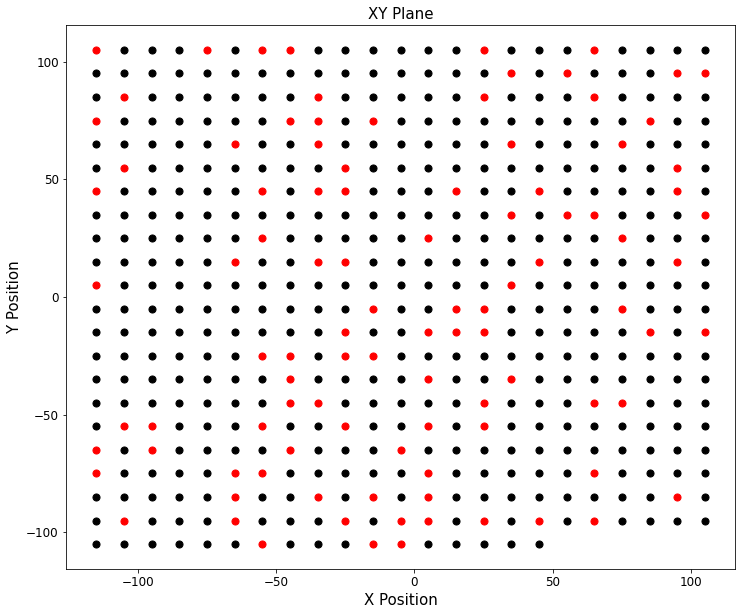

In [8]:
simulation_info={
    
        'LJ_T': False,
    
        'Hard_Core_Collision': True,
        'Noise_T': True,
        'Noise_R':True,
        'Self_Propel_T': True, 
    
        'HI_T':False, 
        'HI_R': False, 
        'Flow_T': False, 
        'Flow_R': False, 
        'Phoresis_T': True, 
        'Phoresis_R': False,
        
        'Np': 500,
        
        'box_length': 250,
        'max_box_lengths':2,
        'periodic': False,
    
        'diam': 4.0,
        
        'vp': 6.86,
        'epsilon_LJ':4.14e-9,
        'overlap_limit': 4.0,
        'kbT': 4.14e-9, 
        'visc':1e-9,
        'zeta_T_passive': 100.0,
        'zeta_T_active': 0.0,
        'zeta_R_active': 0.0,
        'Dc': 4.0,
        'k':12.56,
        'flow_uniform': 0.0, 
        'flow_shear': 0.0,

        'Initial Position':[],
        'Initial Orientation':[],
        'Active':[],
        
        'Tf': 2700,
        'Npts':2700,
    
        'Minimum Timestep': 0.001,
        'Filename':'Phoretic_Run_100',
}

Np=simulation_info['Np']
diam= simulation_info['diam']
box_length=simulation_info['box_length']
filename=simulation_info['Filename'] +'.pickle'



simulation_info['Initial Position']=initialize_square(Np, diam, box_length)
simulation_info['Initial Orientation']=initialize_random(Np)
simulation_info['Active']=active_random(Np,100)

plot_positions_2D(simulation_info)

save_simulation_info(simulation_info,filename)



In [12]:
for i in range(99,100):
    pickle_filename='Phoretic_Run_'+str(i+1)+'.pickle'
    print(pickle_filename)
    simulation_info=load_simulation_info(pickle_filename)
    print(simulation_info)
    simulation=Simulation(simulation_info)
    simulation.run_simulation()

Phoretic_Run_100.pickle
{'LJ_T': False, 'Hard_Core_Collision': True, 'Noise_T': True, 'Noise_R': True, 'Self_Propel_T': True, 'HI_T': False, 'HI_R': False, 'Flow_T': False, 'Flow_R': False, 'Phoresis_T': True, 'Phoresis_R': False, 'Np': 500, 'box_length': 250, 'max_box_lengths': 2, 'periodic': False, 'diam': 4.0, 'vp': 6.86, 'epsilon_LJ': 4.14e-09, 'overlap_limit': 4.0, 'kbT': 4.14e-09, 'visc': 1e-09, 'zeta_T_passive': 100.0, 'zeta_T_active': 0.0, 'zeta_R_active': 0.0, 'Dc': 4.0, 'k': 12.56, 'flow_uniform': 0.0, 'flow_shear': 0.0, 'Initial Position': array([-115., -105.,  -95.,  -85.,  -75.,  -65.,  -55.,  -45.,  -35.,
        -25.,  -15.,   -5.,    5.,   15.,   25.,   35.,   45.,   55.,
         65.,   75.,   85.,   95.,  105., -115., -105.,  -95.,  -85.,
        -75.,  -65.,  -55.,  -45.,  -35.,  -25.,  -15.,   -5.,    5.,
         15.,   25.,   35.,   45.,   55.,   65.,   75.,   85.,   95.,
        105., -115., -105.,  -95.,  -85.,  -75.,  -65.,  -55.,  -45.,
        -35.,  -25.,  -

KeyboardInterrupt: 